# Bitcoin link prediction

Material for Lecture 4 of the Risk Analytics workshop at the University of Ljubljana.

Please note: this implementation has not been optimized and is in need of refactoring.

In [1]:
import os
import sys

import json
from pprint import pprint

import requests

from itertools import combinations_with_replacement as cwr

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import networkx as nx

from gensim.models import Word2Vec

from sklearn.metrics import roc_auc_score as auc

#from node2vec import node2vec as n2v
#from node2vec import node2vec as n2v

from importlib import reload

#reload(n2v)

pd.options.mode.chained_assignment = None
plt.style.use('ggplot')
%matplotlib inline

In [2]:
def learn_embeddings(walks, dimensions, window_size, workers, n_iter=1):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    
    # Python 2 or 3
    if sys.version_info.major < 3:
        walks = [map(str, walk) for walk in walks]
    else: # Python 3
        walks = [list(map(str,walk)) for walk in walks]
        
    model = Word2Vec(walks, size=dimensions, window=window_size, min_count=0, sg=1, workers=workers, iter=n_iter)
    #model.save_word2vec_format(args.output)
    return model


def common_neighbor(pair, G):
    com_nbr = len(list(nx.common_neighbors(G, pair[0], pair[1])))

    return com_nbr


def hadamard(pair, model):
    hadamard = np.dot(model.wv[pair[0]], model.wv[pair[1]])
    
    return hadamard

# Modified version of https://github.com/aditya-grover/node2vec/blob/master/src/node2vec.py
import random

class n2vGraph():
    def __init__(self, nx_G, is_directed, p, q):
        self.G = nx_G
        self.is_directed = is_directed
        self.p = p
        self.q = q

    def node2vec_walk(self, walk_length, start_node):
        '''
        Simulate a random walk starting from start node.
        '''
        G = self.G
        alias_nodes = self.alias_nodes
        alias_edges = self.alias_edges

        walk = [start_node]

        while len(walk) < walk_length:
            cur = walk[-1]
            cur_nbrs = sorted(G.neighbors(cur))
            if len(cur_nbrs) > 0:
                if len(walk) == 1:
                    walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
                else:
                    prev = walk[-2]
                    next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0], 
                        alias_edges[(prev, cur)][1])]
                    walk.append(next)
            else:
                break

        return walk

    def simulate_walks(self, num_walks, walk_length):
        '''
        Repeatedly simulate random walks from each node.
        '''
        G = self.G
        walks = []
        nodes = list(G.nodes())
        print('Walk iteration:')
        for walk_iter in range(num_walks):
            print(str(walk_iter+1), '/', str(num_walks))
            random.shuffle(nodes)
            for node in nodes:
                walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))

        return walks

    def get_alias_edge(self, src, dst):
        '''
        Get the alias edge setup lists for a given edge.
        '''
        G = self.G
        p = self.p
        q = self.q

        unnormalized_probs = []

        # PL mod: differentiate between graphs types (multi or not)
        # PL TODO: make random walk also along random connecting edgnes, not just 0th
        if isinstance(G, nx.multigraph.MultiGraph):
            for dst_nbr in sorted(G.neighbors(dst)):
                if dst_nbr == src:
                    # Multigraph TODO: can be more than one edge, 0 only the 1st one 
                    unnormalized_probs.append(G[dst][dst_nbr][0]['weight']/p)
                elif G.has_edge(dst_nbr, src):
                    # Multigraph TODO: can be more than one edge, 0 only the 1st one
                    unnormalized_probs.append(G[dst][dst_nbr][0]['weight'])
                else:
                    # Multigraph TODO: can be more than one edge, 0 only the 1st one
                    unnormalized_probs.append(G[dst][dst_nbr][0]['weight']/q)
        else: # Is not multigraph:
            for dst_nbr in sorted(G.neighbors(dst)):
                if dst_nbr == src:
                    # Multigraph TODO: can be more than one edge, 0 only the 1st one 
                    unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
                elif G.has_edge(dst_nbr, src):
                    # Multigraph TODO: can be more than one edge, 0 only the 1st one
                    unnormalized_probs.append(G[dst][dst_nbr]['weight'])
                else:
                    # Multigraph TODO: can be more than one edge, 0 only the 1st one
                    unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
        norm_const = sum(unnormalized_probs)
        normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]

        return alias_setup(normalized_probs)

    def preprocess_transition_probs(self):
        '''
        Preprocessing of transition probabilities for guiding the random walks.
        '''
        G = self.G
        is_directed = self.is_directed

        alias_nodes = {}
        for node in G.nodes():
            unnormalized_probs = [G[node][nbr][0]['weight'] for nbr in sorted(G.neighbors(node))]
            norm_const = sum(unnormalized_probs)
            normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]
            alias_nodes[node] = alias_setup(normalized_probs)

        alias_edges = {}
        triads = {}

        if is_directed:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
        else:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
                alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])

        self.alias_nodes = alias_nodes
        self.alias_edges = alias_edges

        return


def alias_setup(probs):
    '''
    Compute utility lists for non-uniform sampling from discrete distributions.
    Refer to https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    for details
    '''
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int)

    smaller = []
    larger = []
    for kk, prob in enumerate(probs):
        q[kk] = K*prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def alias_draw(J, q):
    '''
    Draw sample from a non-uniform discrete distribution using alias sampling.
    '''
    K = len(J)

    kk = int(np.floor(np.random.rand()*K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]


def learn_embeddings(walks, dimensions, window_size, workers, n_iter=1):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    Transplanted from main.py and make Python 3 compatible
    '''
    
    # Python 2 or 3
    if sys.version_info.major < 3:
        walks = [map(str, walk) for walk in walks]
    else: # Python 3
        walks = [list(map(str,walk)) for walk in walks]
        
    model = Word2Vec(walks, size=dimensions, window=window_size, min_count=0, sg=1, workers=workers, iter=n_iter)
    #model.save_word2vec_format(args.output)
    return model

# Do link prediction on the bitcoin transaction network

In [3]:
save_me = False
graph_df = pd.read_csv("../data/btc_df.csv")
graph_df.head()

,value,spent_flag,height,addr_from,addr_to
0,5000000000,False,0,mining,1A1zP1eP5QGefi2DMPTfTL5SLmv7DivfNa
1,5000000000,False,1,mining,12c6DSiU4Rq3P4ZxziKxzrL5LmMBrzjrJX
2,5000000000,False,2,mining,1HLoD9E4SDFFPDiYfNYnkBLQ85Y51J3Zb1
3,5000000000,False,3,mining,1FvzCLoTPGANNjWoUo6jUGuAG3wg1w4YjR
4,5000000000,False,4,mining,15ubicBBWFnvoZLT7GiU2qxjRaKJPdkDMG


In [ ]:
# Filter out the mining transactions
graph_df = graph_df.loc[~(graph_df.addr_from == 'mining'), :]
graph_df = graph_df.rename(columns={'value': 'weight'})

run_list = []
for height_max in range(55000, 60000, 1000):
    run_dict = {}
    print(height_max)
    height_train = int(height_max*0.90)

    run_dict['height_max'] = height_max
    run_dict['height_train'] = height_train
    graph_h = graph_df.loc[graph_df.height < height_max, :]
    graph_train = graph_h.loc[graph_h.height < height_train, :]
    graph_test = graph_h.loc[graph_h.height >= height_train, :]

    # Create edge train and test sets
    edge_df = graph_h[['addr_from', 'addr_to']]#, 'weight']]
    edge_df['data'] = graph_h[['weight', 'height']].to_dict(orient='records')
    #edge_df['data'] = graph_df[['weight']].to_dict(orient='records')
    edge_list = edge_df.values.tolist()

    edge_train = graph_train[['addr_from', 'addr_to']]#, 'weight']]
    edge_train['data'] = graph_train[['weight', 'height']].to_dict(orient='records')
    #edge_df['data'] = graph_df[['weight']].to_dict(orient='records')
    edge_train_list = edge_train.values.tolist()

    edge_test = graph_test[['addr_from', 'addr_to']]#, 'weight']]
    edge_test['data'] = graph_test[['weight', 'height']].to_dict(orient='records')
    #edge_df['data'] = graph_df[['weight']].to_dict(orient='records')
    edge_test_list = edge_test.values.tolist()


    # Create graphs, full, train and test
    G = nx.MultiDiGraph(edge_list)
    G_train = nx.MultiDiGraph(edge_train_list)
    G_test = nx.MultiDiGraph(edge_test_list)
    #nx.draw_networkx(G, with_labels=False, node_size = 80)

    print("Number of nodes: {0}\nNumber of edges: {1}".format(G.number_of_nodes(), G.number_of_edges()))
    print("Number of train nodes: {0}\nNumber of edges: {1}".format(G_train.number_of_nodes(), G_train.number_of_edges()))
    print("Number of test nodes: {0}\nNumber of edges: {1}".format(G_test.number_of_nodes(), G_test.number_of_edges()))

    # Keep only nodes with valency at least 3
    nodes_ge3 = [n for n in G.nodes() if G.in_degree(n) + G.out_degree(n) >=3]
    G = G.subgraph(nodes_ge3)
    #degs_in = G.in_degree()
    #print(degs_in, '\n')
    #degs_out = G.out_degree()

    nodes_train_ge3 = [n for n in G_train.nodes() if G_train.in_degree(n) + G_train.out_degree(n) >=3]
    G_train = G_train.subgraph(nodes_train_ge3)
    #degs_train_in = G_train.in_degree()
    #print(degs_in, '\n')
    #degs_train_out = G_train.out_degree()

    nodes_test_ge3 = [n for n in G_test.nodes() if G_test.in_degree(n) + G_test.out_degree(n) >=3]
    G_test = G_test.subgraph(nodes_test_ge3)


    G_und = G.to_undirected()
    G_train_und = G_train.to_undirected()
    G_test_und = G_test.to_undirected()
    # Assign transaction amount as weight
    print("Number of nodes: {0}\nNumber of edges: {1}".format(G.number_of_nodes(), G.number_of_edges()))
    print("Number of nodes: {0}\nNumber of edges: {1}".format(G_train.number_of_nodes(), G_train.number_of_edges()))
    print("Number of nodes: {0}\nNumber of edges: {1}".format(G_test.number_of_nodes(), G_test.number_of_edges()))

    run_dict['n_train_nodes'] = G_train.number_of_nodes()
    run_dict['n_train_edges'] = G_train.number_of_edges()
    run_dict['n_test_nodes'] = G_test.number_of_nodes()
    run_dict['n_test_edges'] = G_test.number_of_edges()

    # node2vec parameters
    p, q = 1,3

    G_n2v = n2vGraph(G_train, True, p, q)
    G_n2v.preprocess_transition_probs()


    walks = G_n2v.simulate_walks(20, 10)

    # word2vec params
    dimensions = 100
    window_size = 5
    workers =4
    n_iter = 10
    model = learn_embeddings(walks, dimensions, window_size, workers, n_iter=n_iter)

    # Define train and test node pairs and edges
    pairs_train = cwr(G_train.nodes(), 2)
    pairs_train_list = list(pairs_train)

    pairs_test = cwr(G_test.nodes(), 2)
    pairs_test_list = list(set(pairs_test).intersection(set(pairs_train_list)))

    e_train = G_train.edges()
    e_test = G_test.edges()

    # Create dataframe for training and testing
    %time edge_mask = [pair in e_train or (pair[1], pair[0]) in e_train for pair in pairs_train_list]
    train_df = pd.DataFrame({'node_pair': pairs_train_list})
    train_df['edge_mask'] = edge_mask
    %time train_df['com_nbr'] = [common_neighbor(pair, G_train_und) for pair in pairs_train_list]
    %time train_df['hadamard'] = [np.dot(model.wv[pair[0]], model.wv[pair[1]]) for pair in pairs_train_list]

    print(train_df.shape)
    print(sum(train_df['edge_mask']))
    print(auc(train_df['edge_mask'], train_df['com_nbr']))
    print(auc(train_df['edge_mask'], train_df['hadamard']))
    run_dict['auc_common_neighbors_train'] = auc(train_df['edge_mask'], train_df['com_nbr'])
    run_dict['auc_n2v_train'] = auc(train_df['edge_mask'], train_df['hadamard'])
    
    %time edge_mask = [pair in e_test or (pair[1], pair[0]) in e_test for pair in pairs_test_list]
    test_df = pd.DataFrame({'node_pair': pairs_test_list})
    test_df['edge_mask'] = edge_mask
    %time test_df['com_nbr'] = [common_neighbor(pair, G_test_und) for pair in pairs_test_list]
    %time test_df['hadamard'] = [np.dot(model.wv[pair[0]], model.wv[pair[1]]) for pair in pairs_test_list]

    print(auc(test_df['edge_mask'], test_df['com_nbr']))
    print(auc(test_df['edge_mask'], test_df['hadamard']))
    run_dict['auc_common_neighbors_test'] = auc(test_df['edge_mask'], test_df['com_nbr'])
    run_dict['auc_n2v_test'] = auc(test_df['edge_mask'], test_df['hadamard'])
    
    run_list.append(run_dict)

55000
Number of nodes: 16395
Number of edges: 22869
Number of train nodes: 8971
Number of edges: 10928
Number of test nodes: 7495
Number of edges: 11941
Number of nodes: 3673
Number of edges: 7681
Number of nodes: 242
Number of edges: 417
Number of nodes: 3442
Number of edges: 7194
Walk iteration:
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20
CPU times: user 706 ms, sys: 427 µs, total: 707 ms
Wall time: 707 ms
CPU times: user 115 ms, sys: 335 µs, total: 115 ms
Wall time: 115 ms
CPU times: user 81.9 ms, sys: 409 µs, total: 82.3 ms
Wall time: 82.3 ms
(29403, 4)
246
0.691062347911
0.78817662495
CPU times: user 56.2 ms, sys: 112 µs, total: 56.3 ms
Wall time: 56.5 ms
CPU times: user 861 µs, sys: 3 µs, total: 864 µs
Wall time: 867 µs
CPU times: user 1 ms, sys: 396 µs, total: 1.4 ms
Wall time: 1.06 ms
0.665441176471
0.901960784314
56000
Number of nodes: 17335
Number of edges: 25970
Number 

In [21]:
run_df = pd.DataFrame(run_list)

In [19]:
#run = pd.Series(run_dict)
run_df.set_index('height_max', inplace=True)
if save_me:
    run_df.to_csv('../results/n2v_runs.csv', header=False)
run_df

,auc_common_neighbors_test,auc_common_neighbors_train,auc_n2v_test,auc_n2v_train,height_train,n_test_edges,n_test_nodes,n_train_edges,n_train_nodes
height_max,,,,,,,,,
55000,0.665441,0.691062,0.901961,0.788177,49500,7194,3442,417,242
56000,0.659608,0.679586,0.875294,0.787426,50400,8963,3445,626,310
57000,0.568829,0.697628,0.803534,0.798863,51300,8959,3418,812,398
58000,0.698035,0.770120,0.800992,0.557449,52200,2867,356,7157,3494
59000,0.686362,0.774356,0.782166,0.568173,53100,2799,325,7342,3563


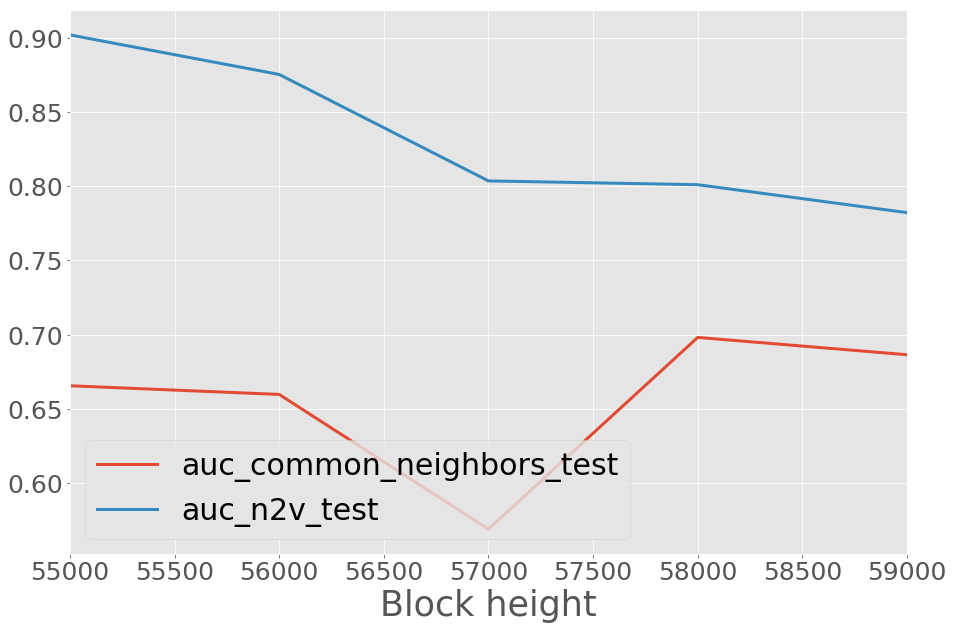

In [20]:
fig_dir = "../slides/figures"
plt.figure();
ax = run_df[['auc_common_neighbors_test', 'auc_n2v_test']].plot(figsize=(15, 10), linewidth=3.0);
ax.set_xlabel("Block height", fontsize=35)
plt.legend(loc=3, prop={'size': 30})
plt.tick_params(axis='both', which='major', labelsize=25)
if save_me:
    plt.savefig(os.path.join(fig_dir, "cn_vs_n2v.png"), format='png')

## Problems: Link Prediction

### Link prediction heuristics

1. Implement the Jaccard coefficient and compare its performance to Common Neighbors and node2vec
2. Same for Adamic-Adir
3. Same for Preferential Attachment

### Refactor the above for loop over `height_max`

Possible improvements:

1. `*` Select sections of code to refactor as functions to both encapsulate and make the code more readable
2. `**` Use dask or some other package to use parallelize the for loop
3. `**` Refactor the split into train and test graphs to ensure a more consistent split between the number of training and testing nodes

### Improve node2vec link prediction

1. `*` Change the parameters of node2vec (e.g. embedding dimension, number and length of walks, p, q) to try to increase the prediction power

## Problem: Mini-mining

Find the smallest non-negative seed for np.random.uniform in Python (or runif in R) such that

1. The first random number starts with one zero
2. The first random number starts with two zeros